# **1. Prepare Data**

## **1.1 Mount Google Drive**

In [1]:
# Mount google drive for files and folder
from google.colab import drive
drive.mount("/content/Drive/", force_remount=True)

Mounted at /content/Drive/


## **1.2 Basic Imports**

In [2]:
# Basic python imports
import os
import shutil
!pip install tabulate --quiet
from tabulate import tabulate

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## **1.3 Extract the Audio Data**

In [3]:
# Path to dataset zip file
dataset_path = os.path.normpath("/content/Drive/MyDrive/Deep-Audio-Classification/archive.zip")

In [4]:
# Check if data folder already exists
if "data" not in os.listdir("/content/"):
    # Create folder to store the data
    os.makedirs("/content/data/")

    # Extract the file to the data folder
    shutil.unpack_archive(dataset_path, "/content/data/")

## **1.4 View the Audio Composition**

In [5]:
# Base path to dataset
dataset_path = os.path.normpath("/content/data/")

# Table headers
table_headers = ["Folder", "No. of Audio Files"]
table_data = []

# Traverse over the folders
for folder in os.listdir(dataset_path):
    # Update the list with folder and audio count
    table_data.append([os.path.join(dataset_path, folder), len(os.listdir(os.path.join(dataset_path, folder)))])

# Print the table
print(tabulate(table_data, table_headers, tablefmt="grid"))

+---------------------------------------------+----------------------+
| Folder                                      |   No. of Audio Files |
+=============================================+======================+
| /content/data/Parsed_Not_Capuchinbird_Clips |                  593 |
+---------------------------------------------+----------------------+
| /content/data/Forest Recordings             |                  100 |
+---------------------------------------------+----------------------+
| /content/data/Parsed_Capuchinbird_Clips     |                  217 |
+---------------------------------------------+----------------------+


# **2. Install and Import Dependencies**

## **2.1 Install Dependencies**

In [6]:
# Install packages
!pip uninstall tensorflow --quiet --yes
!pip uninstall tensorflow-io --quiet --yes

!pip install pip install tensorflow==2.10.0 tensorflow-io==0.27.0 --quiet

In [7]:
# Save installed packages to requirements file -> Google Colab - Dec 2023
!pip freeze > requirements.txt

## **2.2 Load Dependencies**

In [8]:
# Import requried packages
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# **3. Build Data Loading Function**

## **3.1 Define Paths to Files**

In [9]:
# Define paths
CAPUCHIN_FILE = os.path.join(dataset_path, "Parsed_Capuchinbird_Clips", "XC3776-3.wav")
NON_CAPUCHIN_FILE = os.path.join(dataset_path, "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-26.wav")

In [10]:
# View paths
CAPUCHIN_FILE, NON_CAPUCHIN_FILE

('/content/data/Parsed_Capuchinbird_Clips/XC3776-3.wav',
 '/content/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-26.wav')

## **3.2 Build a Dataloading Function**

In [11]:
# Function to load and process the data
def load_wav_16k_mono(filename):
    # Load the encoded wav file
    file_contents = tf.io.read_file(filename)

    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    # Remove trailing axis
    wav = tf.squeeze(wav, axis=-1)

    # Cast the sample rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Goes from 44100hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    # Return the wave data
    return wav

## **3.3 Plot Wave**

In [12]:
# Get the wave data for the files
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NON_CAPUCHIN_FILE)

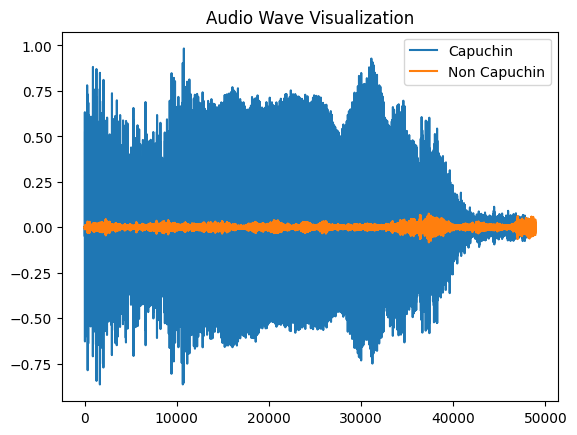

In [13]:
# Plot the waves
plt.plot(wave)
plt.plot(nwave)
plt.legend(["Capuchin", "Non Capuchin"])
plt.title("Audio Wave Visualization")
plt.show()

# **4. Create Tensorflow Dataset**

## **4.1 Define Paths to Positive and Negative Data**

In [14]:
# Define the paths
POS = os.path.join(dataset_path, "Parsed_Capuchinbird_Clips")
NEG = os.path.join(dataset_path, "Parsed_Not_Capuchinbird_Clips")

In [15]:
# Print the path
POS, NEG

('/content/data/Parsed_Capuchinbird_Clips',
 '/content/data/Parsed_Not_Capuchinbird_Clips')

## **4.2 Create Tensorflow Datasets**

In [16]:
# Prepare the dataset
POS_DF = tf.data.Dataset.list_files(os.path.join(POS, "*.wav"))
NEG_DF = tf.data.Dataset.list_files(os.path.join(NEG, "*.wav"))

## **4.3 Add Label and Combine Positive and Negative Samples**

In [17]:
# Assign lables to data
positives = tf.data.Dataset.zip((POS_DF, tf.data.Dataset.from_tensor_slices(tf.ones(len(POS_DF)))))
negatives = tf.data.Dataset.zip((NEG_DF, tf.data.Dataset.from_tensor_slices(tf.zeros(len(NEG_DF)))))

In [18]:
# Join the datasets
data = positives.concatenate(negatives)

# **5. Determine Average Length of a Capuchin Call**

## **5.1  Calculate Wave Cycle Length**

In [19]:
# List to store the lengths of the Capuchin bird calls
lengths = []

# Traveres over the audio files
for file in os.listdir(POS):
    # Get the wave for the audio file
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))

    # Update the list
    lengths.append(len(tensor_wave))

## **5.2 Calculate Mean, Min and Max**

In [20]:
# Imports
import pandas as pd

# Conver the length to pandas series
lengths = pd.Series(lengths)

In [21]:
# Stats for the lengths
lengths.describe()

count      217.000000
mean     54156.663594
std       8191.767002
min      32000.000000
25%      48000.000000
50%      56000.000000
75%      56000.000000
max      80000.000000
dtype: float64

In [22]:
# Stats for the time
(lengths / 16000).describe()

count    217.000000
mean       3.384791
std        0.511985
min        2.000000
25%        3.000000
50%        3.500000
75%        3.500000
max        5.000000
dtype: float64

# **6. Build Preprocessing Function to Converte to Spectrogram**

## **6.1 Build Preprocessing Function**

In [23]:
# Function to convert to image
def preprocess(file_path, label):
    # Get the wave
    wav = load_wav_16k_mono(file_path)

    # Get the first 56000 audio signals for every audio
    wav = wav[:56000]

    # Create zero padding
    zero_padding = tf.zeros([56000] - tf.shape(wav), dtype=tf.float32)

    # Join the wave and padding
    wav = tf.concat([zero_padding, wav], 0)

    # Get the spectrogram
    # Get the absolute values
    # Expand the dimensions
    spectrogram = tf.expand_dims(tf.abs(tf.signal.stft(wav, frame_length=320, frame_step=32)), axis=2)

    # Return the spectrogram and label
    return spectrogram, label

## **6.2 Test Out the Function and Viz the Spectrogram**

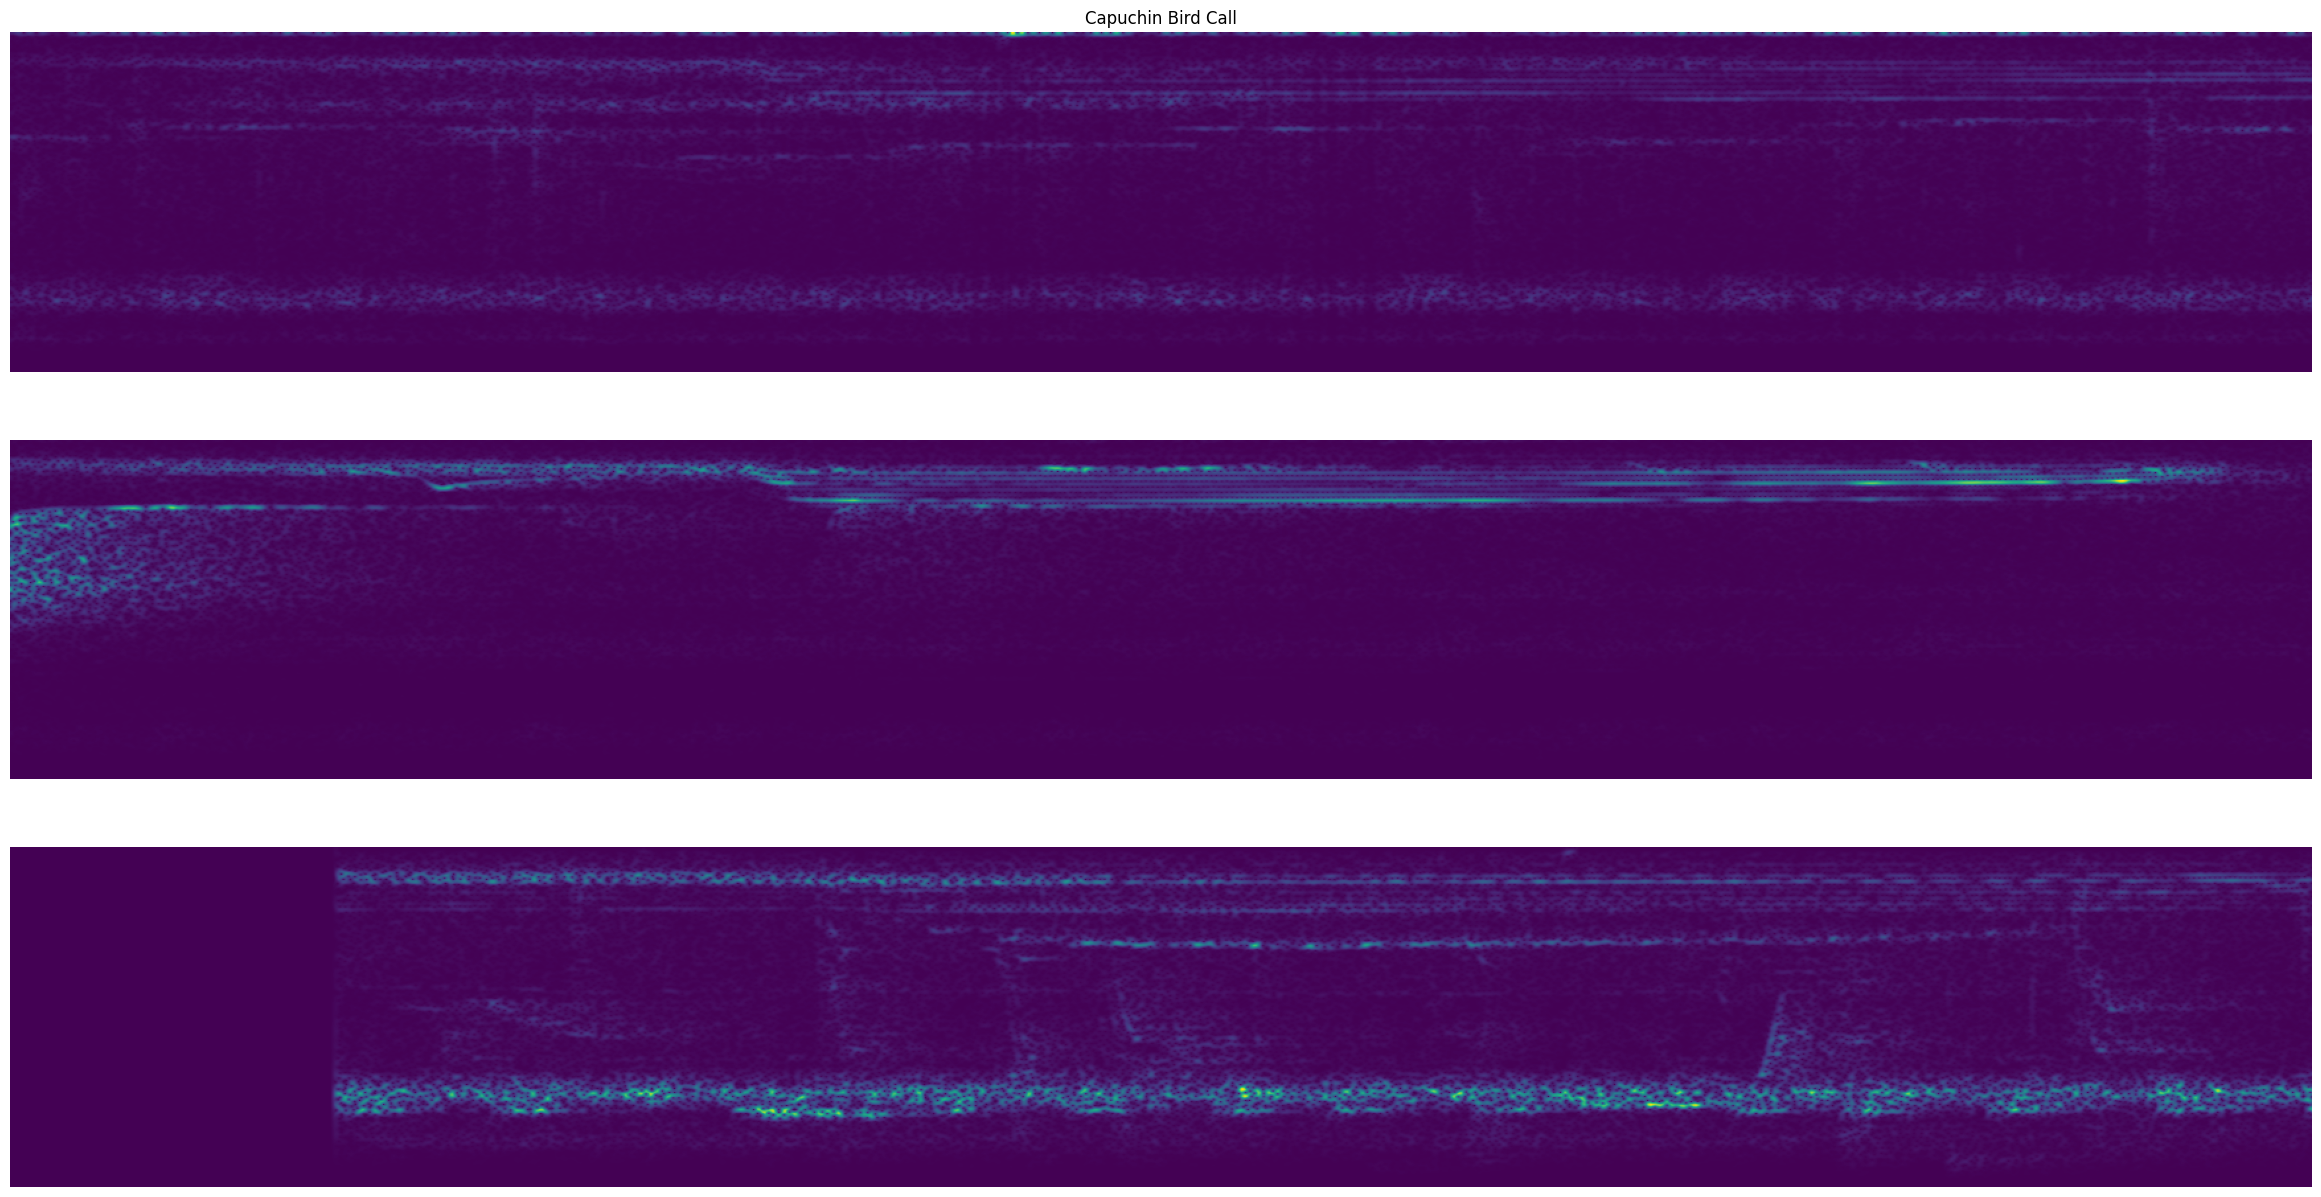

In [24]:
# Get three random items from the positives
num_images = 3
random_positives = positives.shuffle(buffer_size=10000).take(num_images)
pos_iter = random_positives.as_numpy_iterator()

# Create subplots with reduced vertical space
fig, axs = plt.subplots(num_images, 1, figsize=(30, 5 * num_images))

# Process and visualize each image
for i in range(num_images):
    pos_filepath, pos_label = pos_iter.next()
    pos_spectrogram, pos_label = preprocess(pos_filepath, pos_label)

    # Display the image
    axs[i].imshow(tf.transpose(pos_spectrogram)[0])
    axs[i].axis('off')

# Set title
axs[0].set_title("Capuchin Bird Call")

# Show the plot
plt.show()

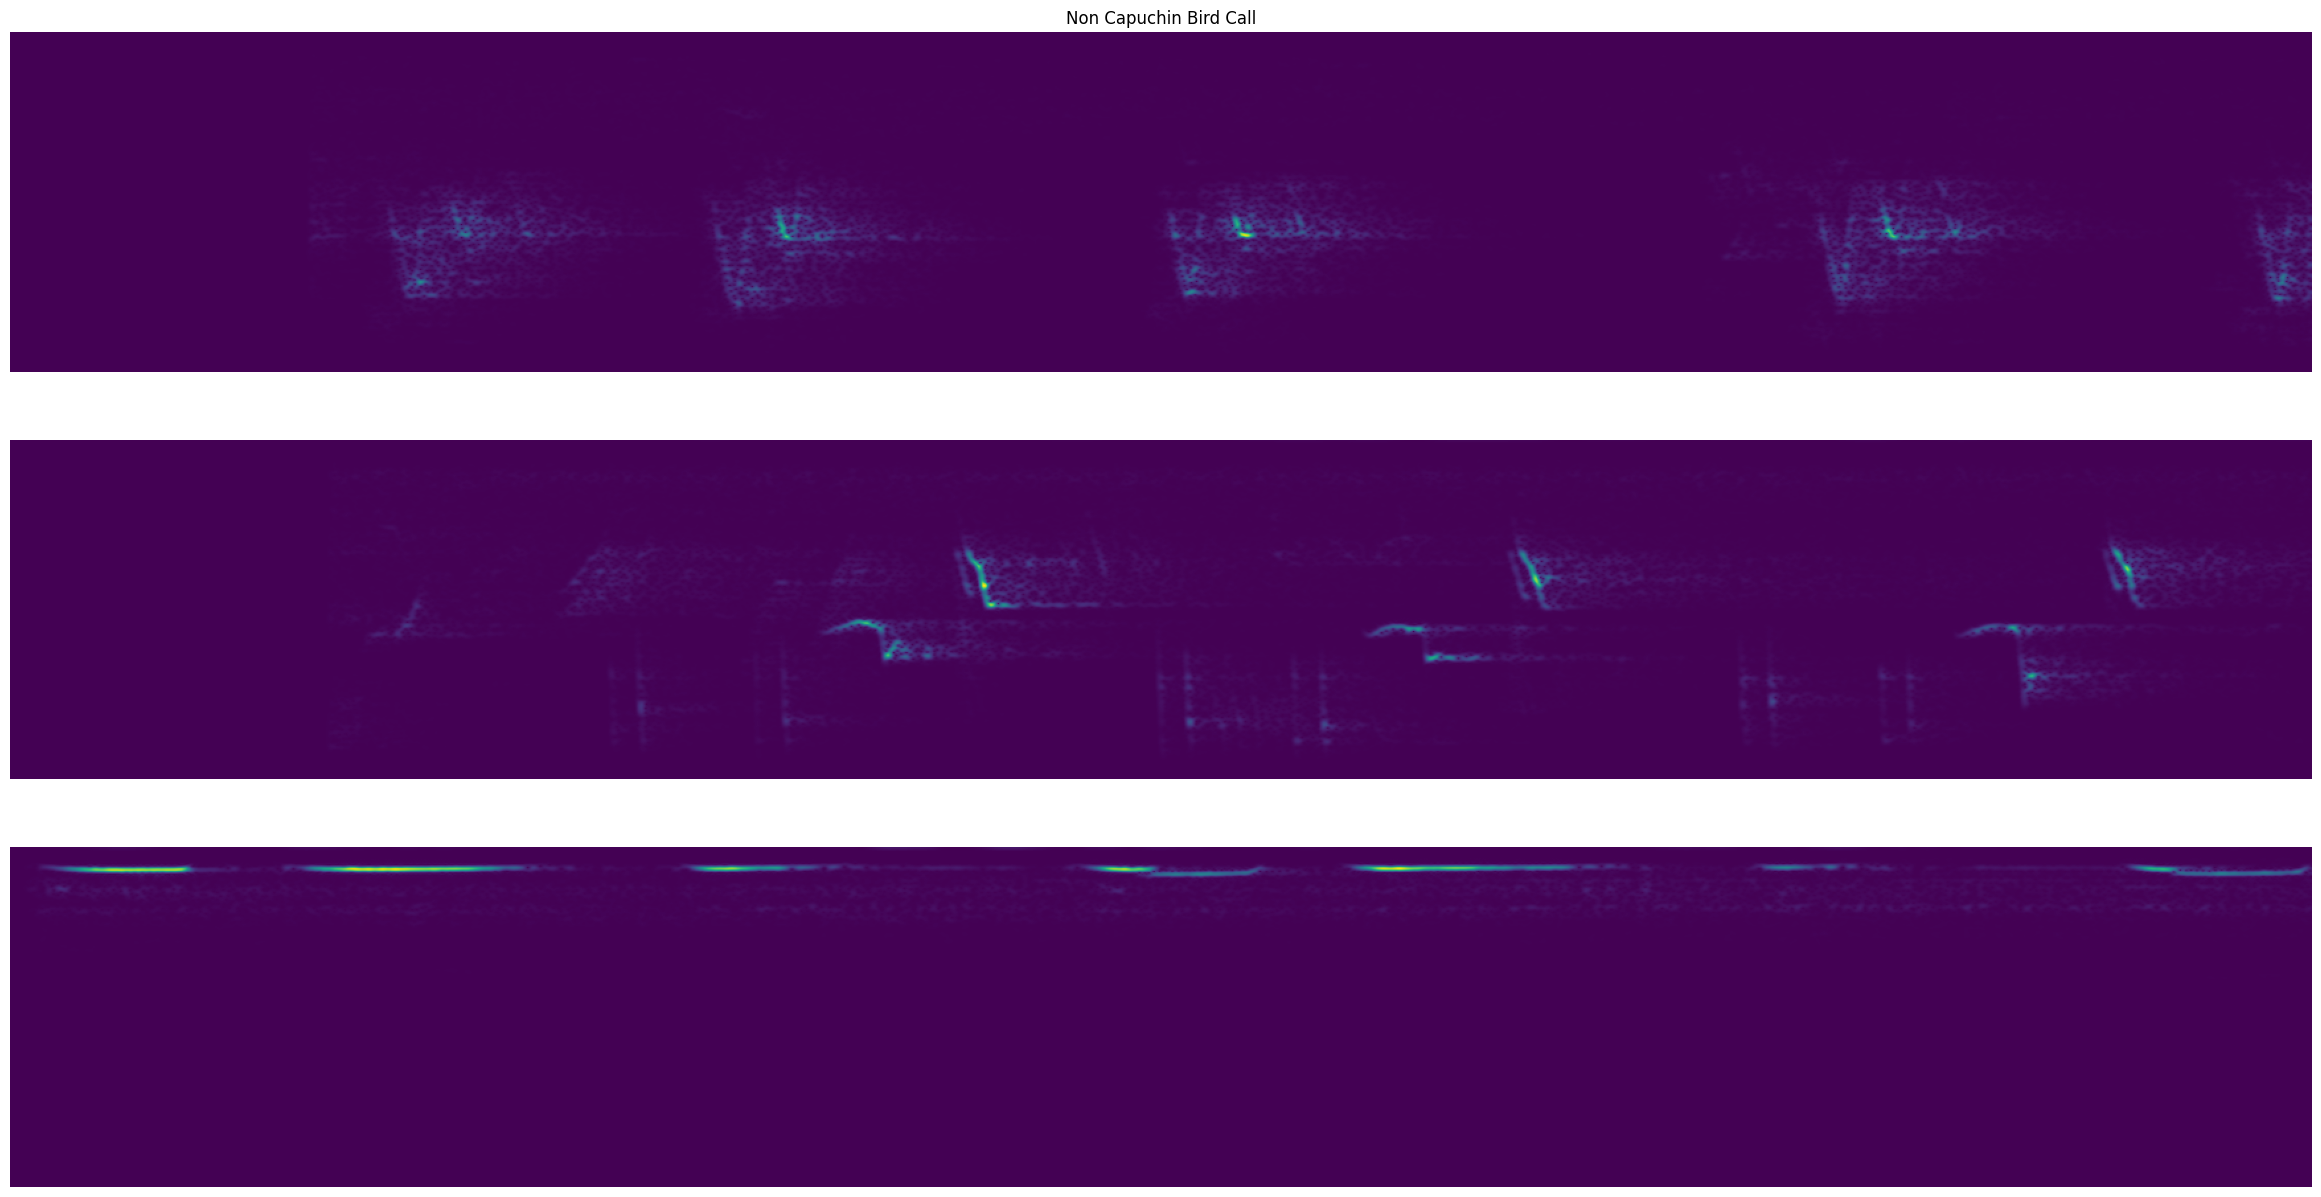

In [25]:
# Get three random items from the negatives
num_images = 3
random_negatives = negatives.shuffle(buffer_size=10000).take(num_images)
neg_iter = random_negatives.as_numpy_iterator()

# Create subplots with reduced vertical space
fig, axs = plt.subplots(num_images, 1, figsize=(30, 5 * num_images))

# Process and visualize each image
for i in range(num_images):
    neg_filepath, neg_label = neg_iter.next()
    neg_spectrogram, neg_label = preprocess(neg_filepath, neg_label)

    # Display the image
    axs[i].imshow(tf.transpose(neg_spectrogram)[0])
    axs[i].axis('off')

# Set title
axs[0].set_title("Non Capuchin Bird Call")

# Show the plot
plt.show()

# **7. Create Training and Testing Partitions**

## **7.1 Create a Tensorflow Data Pipeline**

In [26]:
# Pass the data through all the steps
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## **7.2 Split into Training and Testing Partitions**

In [27]:
# Get the train and test sets
train_df = data.take(36)
test_df = data.skip(36).take(15)

## **7.3 View Sample Batch**

In [28]:
# # Get a sample
# samples, labels = train_df.as_numpy_iterator().next()

# # View the shape of samples
# samples.shape

# **8. Build Deep Learning Model**

## **8.1 Load Tensorflow Dependencies**

In [29]:
# Imports
from tensorflow.keras import *

## **8.2 Build Sequential Model, Compile and View Summary**

In [30]:
# Initialize a sequential model
model = models.Sequential()

# Convolutional block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1741, 257, 1)))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout2D(0.25))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout2D(0.25))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.SpatialDropout2D(0.25))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

# Dense layers with dropout for regularization
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
# Using the Adam Optimizer with a specific learning rate
opt = optimizers.Adam(learning_rate=1e-4)

# Using BinaryCrossentropy as the loss function
loss_function = losses.BinaryCrossentropy()

# Compiling the model with BinaryCrossentropy loss, Adam optimizer, and additional metrics
model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [32]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1739, 255, 32)     320       
                                                                 
 batch_normalization (BatchN  (None, 1739, 255, 32)    128       
 ormalization)                                                   
                                                                 
 spatial_dropout2d (SpatialD  (None, 1739, 255, 32)    0         
 ropout2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 869, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 867, 125, 64)      18496     
                                                        

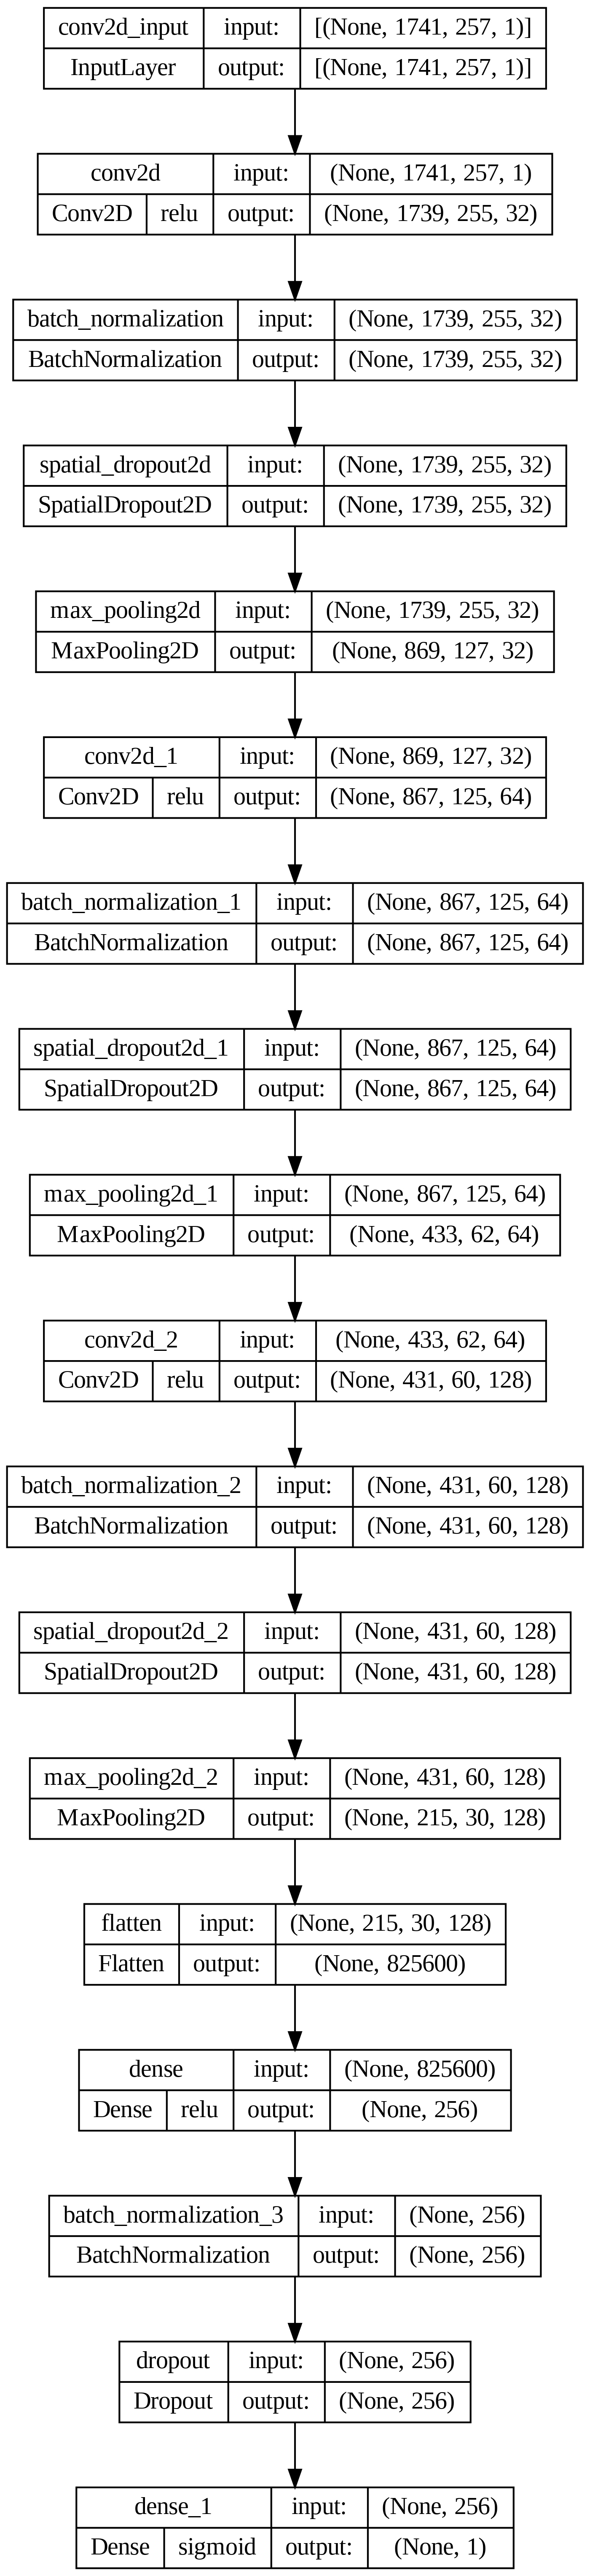

In [33]:
# Plot the model
utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
    dpi=300,
)

## **8.3 Add Model Callbacks**

In [34]:
# File Path to store the trained models
filepath = "./CNN-Models/model_{epoch:02d}-{val_accuracy:.2f}.h5"

# ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Early stopping callback with patience of 5
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)

# Learning rate decay callback using LearningRateScheduler
def lr_schedule(epoch):
    initial_lr = 1e-4
    decay_factor = 0.9
    decay_step = 10
    lr = initial_lr * (decay_factor ** (epoch // decay_step))
    return lr

# Initialize the learning rate scheduler
lr_decay = callbacks.LearningRateScheduler(lr_schedule)

# List of callbacks including ModelCheckpoint and LearningRateScheduler
callbacks_list = [early_stopping, checkpoint, lr_decay]

## **8.4 Train the Model**

In [35]:
# Clear RAM
import gc
gc.collect()

11916

In [36]:
# Triaining the model
history = model.fit(train_df, epochs=5, validation_data=test_df, callbacks=callbacks_list)

Epoch 1/5
36/36 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.8733 - precision: 0.7297 - recall: 0.8544 
Epoch 1: val_accuracy improved from -inf to 0.84615, saving model to ./CNN-Models/model_01-0.85.h5
36/36 [==============================] - 990s 26s/step - loss: 0.5504 - accuracy: 0.8733 - precision: 0.7297 - recall: 0.8544 - val_loss: 0.3148 - val_accuracy: 0.8462 - val_precision: 1.0000 - val_recall: 0.4098 - lr: 1.0000e-04
Epoch 2/5
36/36 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9340 - precision: 0.8436 - recall: 0.9379 
Epoch 2: val_accuracy did not improve from 0.84615
36/36 [==============================] - 891s 25s/step - loss: 0.2193 - accuracy: 0.9340 - precision: 0.8436 - recall: 0.9379 - val_loss: 0.3972 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.3810 - lr: 1.0000e-04
Epoch 3/5
36/36 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9288 - precision: 0.8035 - recall: 0.952

In [37]:
# Clear the RAM
gc.collect()

0

## **8.5 Visualize Model Performance**

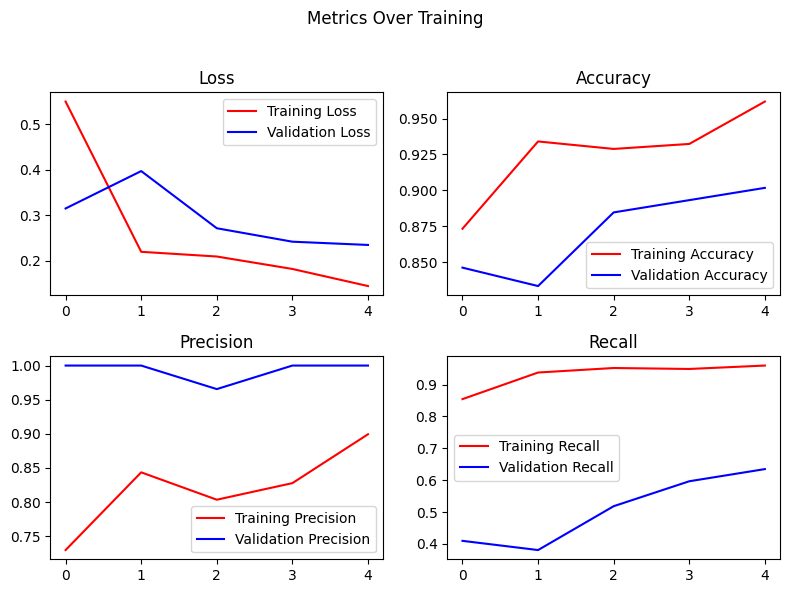

In [52]:
# Assuming 'history' is your pandas DataFrame
metrics = ['loss', 'accuracy', 'precision', 'recall']
colors = ['red', 'blue']

# Create a figure and axis for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
fig.suptitle('Metrics Over Training')

# Traverse over metrics
for i, metric in enumerate(metrics):
    # Get the quotient and remainder
    row, col = divmod(i, 2)

    # Plot training values
    axes[row, col].plot(history.history[metric], color=colors[0], label=f'Training {metric.capitalize()}')

    # Plot validation values
    axes[row, col].plot(history.history[f'val_{metric}'], color=colors[1], label=f'Validation {metric.capitalize()}')

    # Get the title and legend
    axes[row, col].set_title(metric.capitalize())
    axes[row, col].legend()

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

## **8.6 Copy Files to Drive**

In [50]:
# Imports
import glob

# Find the highest accuracy model and store it
shutil.copy(sorted(glob.glob("/content/CNN-Models/*h5"))[-1], "/content/Drive/MyDrive/Deep-Audio-Classification/")
shutil.copy("/content/model.png", "/content/Drive/MyDrive/Deep-Audio-Classification/")
shutil.copy("/content/requirements.txt", "/content/Drive/MyDrive/Deep-Audio-Classification/")

'/content/Drive/MyDrive/Deep-Audio-Classification/requirements.txt'

# **9. Make a Prediction on a Single Clip**

## **9.1 Get One Batch and Make a Prediction**

In [54]:
# Get a sample from the test set
X_test, y_test = test_df.as_numpy_iterator().next()

In [55]:
# View shape of data
X_test.shape, y_test.shape

((16, 1741, 257, 1), (16,))

In [63]:
# Get the predictions
y_pred = model.predict(X_test)

# View the predictions
y_pred

1/1 [==============================] - 5s 5s/step


array([[0.16957428],
       [0.06774911],
       [0.05893298],
       [0.06325881],
       [0.0597444 ],
       [0.08942668],
       [0.18492253],
       [0.785707  ],
       [0.05827362],
       [0.06449463],
       [0.05688059],
       [0.9632795 ],
       [0.07908458],
       [0.05949269],
       [0.6755399 ],
       [0.05909396]], dtype=float32)

## **9.2 Convert Logits to Classes**

In [64]:
# Import
import numpy as np

# Flatten the predictions and convert to classes
y_pred = np.round(y_pred.flatten())

# View the new y_pred
y_pred

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [65]:
# Print out the actual values
y_test

array([1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

## **9.3 Classification Report**

In [66]:
# Import
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        11
         1.0       1.00      0.60      0.75         5

    accuracy                           0.88        16
   macro avg       0.92      0.80      0.83        16
weighted avg       0.89      0.88      0.86        16

